In [9]:
import ast
import json
import re

import matplotlib
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import wandb

In [2]:
feature_map = {
    "c": "co-expression",
    "d": "domain similarity",
    "g": "GO semantic similarity",
    "p": "pathway co-occurrence",
    "s": "sequence similarity",
}


def decode_relations(feature_str):
    """
    1) Split on '_' and take the second piece (index 1).
    2) If 'shuffled' appears in that piece, return 'Shuffled'.
    3) Otherwise, decode each single-letter code.
    """
    parts = feature_str.split("_")
    if len(parts) < 2:
        return feature_str

    second_piece = parts[1]

    decoded = []
    for char in second_piece.lower():
        if char in feature_map:
            decoded.append(feature_map[char])

    decoded.append("PPI")

    return ", ".join(decoded) if decoded else second_piece


def decode_features(feature_str):
    """
    Decode the feature names in a DataFrame.
    """
    parts = feature_str.split("_")
    if len(parts) < 2:
        # If there's no second piece, just return the original string
        return "multi-omics"

    third_piece = parts[2] if len(parts) > 2 else ""

    # Check for "shuffled" (case-insensitive)
    if "shuffled" in third_piece.lower():
        return "shuffled features"
    else:
        return "multi-omics"

In [4]:
df = pd.read_csv("../other/wand_results_25.03.20.csv")
rename_dict = {
    "test_aupr": "AUPR",
    "test_auc": "AUROC",
    "test_accuracy": "ACC",
    "test_f1": "F1",
}
df.rename(columns=rename_dict, inplace=True)
df.dropna(subset=["AUPR", "AUROC", "ACC", "F1"], inplace=True)

In [5]:
df_filtered = df[df["Name"].str.startswith("CPDB")]
df_filtered = df_filtered[df_filtered["Name"].str.contains("nh_32") == False]

In [6]:
df_filtered["Relations"] = df_filtered["Name"].apply(decode_relations)
df_filtered["Features"] = df_filtered["Name"].apply(decode_features)

In [7]:
agg_df = df_filtered.groupby(["Name", "Relations", "Features"], as_index=False).agg(
    {
        "AUPR": ["mean", "std"],
        "AUROC": ["mean", "std"],
        "ACC": ["mean", "std"],
        "F1": ["mean", "std"],
    }
)

In [8]:
agg_df.columns = [
    "Dataset",
    "Relations",
    "Features",
    "AUPR_mean",
    "AUPR_std",
    "AUROC_mean",
    "AUROC_std",
    "ACC_mean",
    "ACC_std",
    "F1_mean",
    "F1_std",
]

In [ ]:
def fmt_mean_std(mean_col, std_col, df, decimals=3):
    return (
        df[mean_col].round(decimals).astype(str)
        + " ± "
        + df[std_col].round(decimals).astype(str)
    )


agg_df["AUPR"] = fmt_mean_std("AUPR_mean", "AUPR_std", agg_df)
agg_df["AUROC"] = fmt_mean_std("AUROC_mean", "AUROC_std", agg_df)
agg_df["ACC"] = fmt_mean_std("ACC_mean", "ACC_std", agg_df)
agg_df["F1"] = fmt_mean_std("F1_mean", "F1_std", agg_df)

In [ ]:
final_df = agg_df[["Relations", "Features", "AUPR", "AUROC", "ACC", "F1"]]

print(final_df.to_markdown(index=False))

| Relations                                                                                                 | Features          | AUPR          | AUROC         | ACC           | F1            |
|:----------------------------------------------------------------------------------------------------------|:------------------|:--------------|:--------------|:--------------|:--------------|
| co-expression, PPI                                                                                        | multi-omics       | 0.813 ± 0.004 | 0.871 ± 0.014 | 0.808 ± 0.012 | 0.821 ± 0.013 |
| co-expression, domain similarity, PPI                                                                     | multi-omics       | 0.822 ± 0.01  | 0.871 ± 0.01  | 0.799 ± 0.037 | 0.81 ± 0.027  |
| co-expression, domain similarity, GO semantic similarity, PPI                                             | multi-omics       | 0.898 ± 0.022 | 0.919 ± 0.01  | 0.856 ± 0.009 | 0.862 ± 0.007 |
| co-expression, domain simila

In [11]:
final_df

,Relations,Features,AUPR,AUROC,ACC,F1
0,"co-expression, PPI",multi-omics,0.813 ± 0.004,0.871 ± 0.014,0.808 ± 0.012,0.821 ± 0.013
1,"co-expression, domain similarity, PPI",multi-omics,0.822 ± 0.01,0.871 ± 0.01,0.799 ± 0.037,0.81 ± 0.027
2,"co-expression, domain similarity, GO semantic ...",multi-omics,0.898 ± 0.022,0.919 ± 0.01,0.856 ± 0.009,0.862 ± 0.007
3,"co-expression, domain similarity, GO semantic ...",multi-omics,0.919 ± 0.007,0.925 ± 0.014,0.907 ± 0.005,0.909 ± 0.005
4,"co-expression, domain similarity, GO semantic ...",multi-omics,0.917 ± 0.013,0.926 ± 0.012,0.891 ± 0.02,0.895 ± 0.02
5,"co-expression, domain similarity, GO semantic ...",shuffled features,0.863 ± 0.03,0.892 ± 0.013,0.87 ± 0.022,0.869 ± 0.025
6,"co-expression, domain similarity, GO semantic ...",multi-omics,0.889 ± 0.013,0.904 ± 0.014,0.862 ± 0.014,0.868 ± 0.012
7,"co-expression, domain similarity, pathway co-o...",multi-omics,0.871 ± 0.017,0.907 ± 0.003,0.883 ± 0.005,0.887 ± 0.003
8,"co-expression, domain similarity, pathway co-o...",multi-omics,0.87 ± 0.031,0.898 ± 0.01,0.875 ± 0.02,0.877 ± 0.02
9,"co-expression, domain similarity, sequence sim...",multi-omics,0.822 ± 0.009,0.866 ± 0.013,0.799 ± 0.012,0.805 ± 0.016


In [ ]:
def extract_mean(cell):
    try:
        return float(cell.split(" ± ")[0])
    except Exception:
        return 0


numeric_df = final_df[["AUPR", "AUROC", "ACC", "F1"]].map(extract_mean)

def heatmap_color(val, vmin, vmax, cmap="YlGnBu", alpha=0.5):
    norm = (val - vmin) / (vmax - vmin) if vmax > vmin else 0.5
    rgba = matplotlib.colormaps.get_cmap(cmap)(norm)
    r, g, b, _ = rgba
    return f"background-color: rgba({int(r * 255)}, {int(g * 255)}, {int(b * 255)}, {alpha})"

def style_column(series, numeric_series, cmap="YlGnBu", alpha=0.5):
    vmin, vmax = numeric_series.min(), numeric_series.max()
    return [heatmap_color(val, vmin, vmax, cmap, alpha) for val in numeric_series]

styled = final_df.style.apply(
    lambda col: style_column(col, numeric_df[col.name])
    if col.name in ["AUPR", "AUROC", "ACC", "F1"]
    else [""] * len(col),
    subset=["AUPR", "AUROC", "ACC", "F1"],
)

styled

,Relations,Features,AUPR,AUROC,ACC,F1
0,"co-expression, PPI",multi-omics,0.813 ± 0.004,0.871 ± 0.014,0.808 ± 0.012,0.821 ± 0.013
1,"co-expression, domain similarity, PPI",multi-omics,0.822 ± 0.01,0.871 ± 0.01,0.799 ± 0.037,0.81 ± 0.027
2,"co-expression, domain similarity, GO semantic similarity, PPI",multi-omics,0.898 ± 0.022,0.919 ± 0.01,0.856 ± 0.009,0.862 ± 0.007
3,"co-expression, domain similarity, GO semantic similarity, pathway co-occurrence, PPI",multi-omics,0.919 ± 0.007,0.925 ± 0.014,0.907 ± 0.005,0.909 ± 0.005
4,"co-expression, domain similarity, GO semantic similarity, pathway co-occurrence, sequence similarity, PPI",multi-omics,0.917 ± 0.013,0.926 ± 0.012,0.891 ± 0.02,0.895 ± 0.02
5,"co-expression, domain similarity, GO semantic similarity, pathway co-occurrence, sequence similarity, PPI",shuffled features,0.863 ± 0.03,0.892 ± 0.013,0.87 ± 0.022,0.869 ± 0.025
6,"co-expression, domain similarity, GO semantic similarity, sequence similarity, PPI",multi-omics,0.889 ± 0.013,0.904 ± 0.014,0.862 ± 0.014,0.868 ± 0.012
7,"co-expression, domain similarity, pathway co-occurrence, PPI",multi-omics,0.871 ± 0.017,0.907 ± 0.003,0.883 ± 0.005,0.887 ± 0.003
8,"co-expression, domain similarity, pathway co-occurrence, sequence similarity, PPI",multi-omics,0.87 ± 0.031,0.898 ± 0.01,0.875 ± 0.02,0.877 ± 0.02
9,"co-expression, domain similarity, sequence similarity, PPI",multi-omics,0.822 ± 0.009,0.866 ± 0.013,0.799 ± 0.012,0.805 ± 0.016


/var/folders/fh/dk_7wcx551n03dv4ztv1_d740000gp/T/ipykernel_34791/2543446060.py:31: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


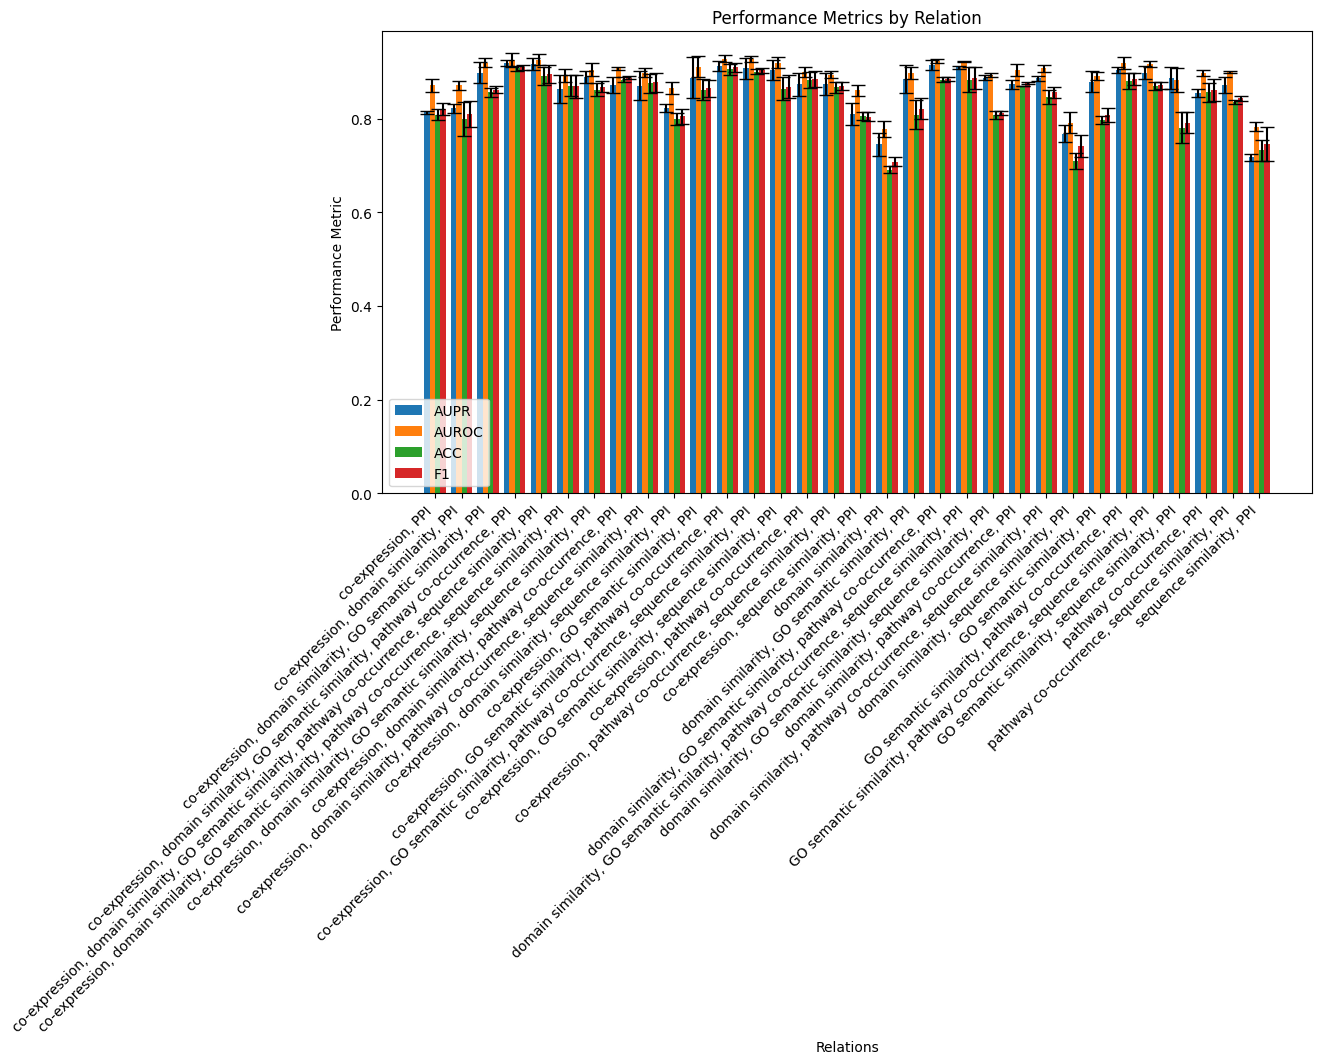

In [ ]:
def parse_metric(metric_str):
    mean_str, std_str = metric_str.split(" ± ")
    return float(mean_str), float(std_str)

relations = final_df["Relations"].tolist()
AUPR_means, AUPR_stds = zip(*final_df["AUPR"].apply(parse_metric))
AUROC_means, AUROC_stds = zip(*final_df["AUROC"].apply(parse_metric))
ACC_means, ACC_stds = zip(*final_df["ACC"].apply(parse_metric))
F1_means, F1_stds = zip(*final_df["F1"].apply(parse_metric))

n_groups = len(relations)
index = np.arange(n_groups)
bar_width = 0.2

plt.figure(figsize=(12, 6))

plt.bar(index, AUPR_means, bar_width, yerr=AUPR_stds, capsize=5, label="AUPR")
plt.bar(
    index + bar_width, AUROC_means, bar_width, yerr=AUROC_stds, capsize=5, label="AUROC"
)
plt.bar(
    index + 2 * bar_width, ACC_means, bar_width, yerr=ACC_stds, capsize=5, label="ACC"
)
plt.bar(index + 3 * bar_width, F1_means, bar_width, yerr=F1_stds, capsize=5, label="F1")

plt.xlabel("Relations")
plt.ylabel("Performance Metric")
plt.title("Performance Metrics by Relation")
plt.xticks(index + 1.5 * bar_width, relations, rotation=45, ha="right")
plt.legend()
plt.tight_layout()
plt.show()

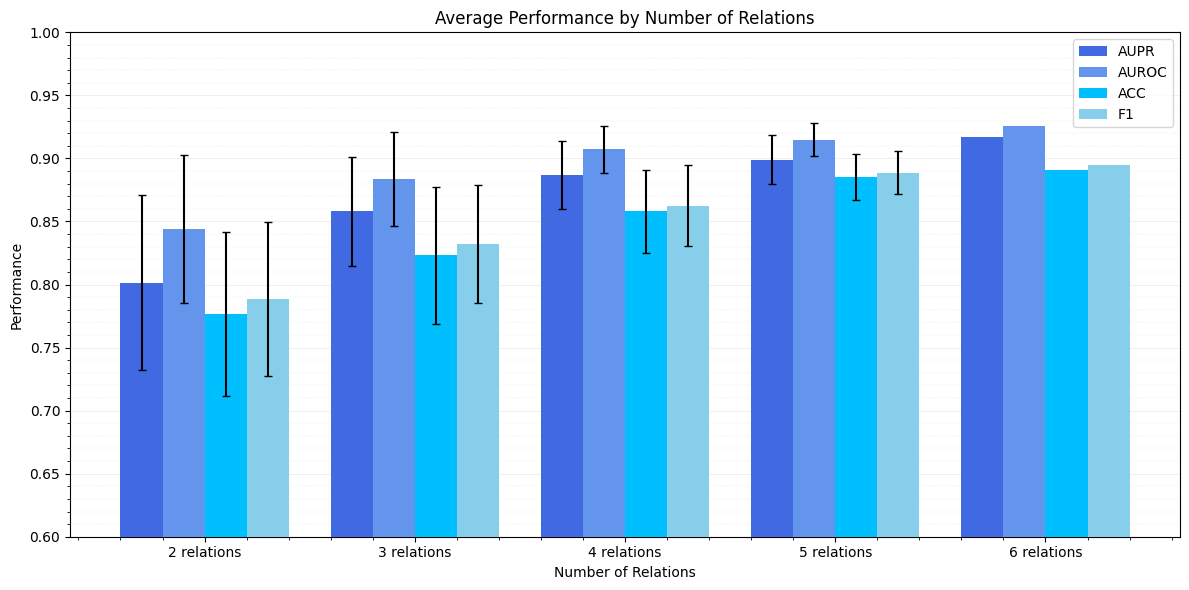

In [ ]:
df_filtered = final_df[final_df["Features"].str.lower() != "shuffled features"].copy()

df_filtered["n_relations"] = df_filtered["Relations"].apply(lambda x: len(x.split(",")))

for metric in ["AUPR", "AUROC", "ACC", "F1"]:
    df_filtered[f"{metric}_mean"] = df_filtered[metric].apply(
        lambda x: float(x.split(" ± ")[0])
    )
    df_filtered[f"{metric}_std"] = df_filtered[metric].apply(
        lambda x: float(x.split(" ± ")[1])
    )
    
grouped = (
    df_filtered.groupby("n_relations")
    .agg(
        {
            "AUPR_mean": ["mean", "std"],
            "AUROC_mean": ["mean", "std"],
            "ACC_mean": ["mean", "std"],
            "F1_mean": ["mean", "std"],
        }
    )
    .reset_index()
)

grouped.columns = [
    "n_relations",
    "AUPR_mean",
    "AUPR_std",
    "AUROC_mean",
    "AUROC_std",
    "ACC_mean",
    "ACC_std",
    "F1_mean",
    "F1_std",
]

grouped["label"] = grouped["n_relations"].apply(lambda x: f"{x} relations")

n_groups = len(grouped)
index = np.arange(n_groups)
bar_width = 0.2

plt.figure(figsize=(12, 6))

plt.bar(
    index,
    grouped["AUPR_mean"],
    bar_width,
    yerr=grouped["AUPR_std"],
    capsize=3,
    label="AUPR",
    color="royalblue",
    zorder=3,
)
plt.bar(
    index + bar_width,
    grouped["AUROC_mean"],
    bar_width,
    yerr=grouped["AUROC_std"],
    capsize=3,
    label="AUROC",
    color="cornflowerblue",
    zorder=3,
)
plt.bar(
    index + 2 * bar_width,
    grouped["ACC_mean"],
    bar_width,
    yerr=grouped["ACC_std"],
    capsize=3,
    label="ACC",
    color="deepskyblue",
    zorder=3,
)
plt.bar(
    index + 3 * bar_width,
    grouped["F1_mean"],
    bar_width,
    yerr=grouped["F1_std"],
    capsize=3,
    label="F1",
    color="skyblue",
    zorder=3,
)

plt.grid(axis="y", alpha=0.5, lw=0.5, color="lightgrey", zorder=0)
plt.minorticks_on()
plt.grid(
    which="minor",
    axis="y",
    alpha=0.5,
    lw=0.25,
    linestyle="--",
    color="lightgrey",
    zorder=0,
)
plt.ylim(0.6, 1)
plt.xlabel("Number of Relations")
plt.ylabel("Performance")
plt.title("Average Performance by Number of Relations")
plt.xticks(index + 1.5 * bar_width, grouped["label"])
plt.legend()
plt.tight_layout()
plt.savefig("../figures/average_performance_by_number_of_relations.png", dpi=300)
plt.show()

### **Download results from WANDB directly**

In [ ]:
api = wandb.Api()
entity, project = "aidd_m", "MORGaN"
runs = api.runs(entity + "/" + project)

summary_list, config_list, name_list = [], [], []
for run in runs:
    summary_list.append(run.summary._json_dict)
    name_list.append(run.name)

runs_df = pd.DataFrame(
    {
        "summary": summary_list,
        "name": name_list,
    }
)

runs_df.to_csv("MORGaN_runs.csv")

KeyboardInterrupt: 

In [ ]:
runs_df = pd.read_csv("MORGaN_runs.csv")


def extract_group_name(name):
    return re.sub(r"_seed_\d+_iter_\d+", "", name)


runs_df["group_name"] = runs_df["name"].apply(extract_group_name)


def parse_summary(x):
    if isinstance(x, dict):
        return x
    if pd.isna(x):
        return {}
    s = x.strip()

    try:
        return ast.literal_eval(s)
    except Exception:
        pass

    try:
        return json.loads(s.replace("'", '"'))
    except Exception:
        pass

    metrics = {}
    for mname in ["test_aupr", "test_auc", "test_accuracy", "test_f1"]:
        pat = rf"{mname}\s*[:=]\s*([0-9]+(?:\.[0-9]+)?)"
        m = re.search(pat, s)
        if m:
            metrics[mname] = float(m.group(1))
    return metrics


runs_df["summary"] = runs_df["summary"].apply(parse_summary)

mask = runs_df["summary"].apply(lambda d: not bool(d)) & runs_df["summary"].notna()
print("Still unparsed:", mask.sum(), "of", len(runs_df))


# Step 2: Extract run type (same as before)
def extract_run_type(name):
    if "edge_ablations" in name:
        return "edge_ablations"
    elif "feature_ablations" in name:
        return "feature_ablations"
    elif "ppi_comparison" in name:
        return "ppi_comparison"
    else:
        return "other"


runs_df["run_type"] = runs_df["name"].apply(extract_run_type)

for metric in ["test_aupr", "test_auc", "test_accuracy", "test_f1"]:
    runs_df[metric] = runs_df["summary"].apply(lambda x: x.get(metric, np.nan))

grouped = runs_df.groupby(["run_type", "group_name"])

def aggregate_metrics(df):
    return pd.Series(
        {
            "AUPR": f"{df['test_aupr'].mean():.3f} ± {df['test_aupr'].std():.3f}",
            "AUC": f"{df['test_auc'].mean():.3f} ± {df['test_auc'].std():.3f}",
            "Accuracy": f"{df['test_accuracy'].mean():.3f} ± {df['test_accuracy'].std():.3f}",
            "F1": f"{df['test_f1'].mean():.3f} ± {df['test_f1'].std():.3f}",
        }
    )


summary_df = grouped.apply(aggregate_metrics).reset_index()

edge_table = summary_df[summary_df["run_type"] == "edge_ablations"].drop(
    columns="run_type"
)
feature_table = summary_df[summary_df["run_type"] == "feature_ablations"].drop(
    columns="run_type"
)
ppi_table = summary_df[summary_df["run_type"] == "ppi_comparison"].drop(
    columns="run_type"
)

Still unparsed: 4 of 629


/var/folders/fh/dk_7wcx551n03dv4ztv1_d740000gp/T/ipykernel_22327/3094155193.py:80: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary_df = grouped.apply(aggregate_metrics).reset_index()


In [17]:
ppi_table

,group_name,AUPR,AUC,Accuracy,F1
141,ppi_comparison_CPDB_cdgps_loss_sce_rpr_0.05_nh...,0.915 ± 0.009,0.914 ± 0.007,0.896 ± 0.008,0.900 ± 0.008
142,ppi_comparison_IRefIndex_2015_cdgps_loss_sce_r...,0.941 ± 0.004,0.936 ± 0.006,0.854 ± 0.026,0.855 ± 0.021
143,ppi_comparison_IRefIndex_cdgps_loss_sce_rpr_0....,0.941 ± 0.004,0.936 ± 0.006,0.854 ± 0.026,0.855 ± 0.021
144,ppi_comparison_PCNet_cdgps_loss_sce_rpr_0.05_n...,0.948 ± 0.007,0.943 ± 0.006,0.897 ± 0.012,0.896 ± 0.010
145,ppi_comparison_STRINGdb_cdgps_loss_sce_rpr_0.0...,0.935 ± 0.005,0.937 ± 0.007,0.902 ± 0.000,0.904 ± 0.001


In [18]:
feature_table

,group_name,AUPR,AUC,Accuracy,F1
124,feature_ablations_CPDB_cdgps_CNA_GE_METH_MF_lo...,0.907 ± 0.013,0.910 ± 0.008,0.896 ± 0.012,0.900 ± 0.013
125,feature_ablations_CPDB_cdgps_CNA_GE_METH_loss_...,0.915 ± 0.007,0.913 ± 0.005,0.900 ± 0.004,0.904 ± 0.004
126,feature_ablations_CPDB_cdgps_CNA_GE_MF_loss_sc...,0.908 ± 0.004,0.911 ± 0.002,0.886 ± 0.011,0.890 ± 0.011
127,feature_ablations_CPDB_cdgps_CNA_GE_loss_sce_r...,0.902 ± 0.005,0.906 ± 0.006,0.878 ± 0.007,0.881 ± 0.007
128,feature_ablations_CPDB_cdgps_CNA_METH_MF_loss_...,0.918 ± 0.013,0.918 ± 0.004,0.898 ± 0.005,0.902 ± 0.005
129,feature_ablations_CPDB_cdgps_CNA_METH_loss_sce...,0.907 ± 0.009,0.914 ± 0.004,0.900 ± 0.004,0.904 ± 0.005
130,feature_ablations_CPDB_cdgps_CNA_MF_loss_sce_r...,0.897 ± 0.005,0.907 ± 0.008,0.892 ± 0.004,0.896 ± 0.004
131,feature_ablations_CPDB_cdgps_CNA_loss_sce_rpr_...,0.912 ± 0.014,0.924 ± 0.009,0.898 ± 0.005,0.903 ± 0.004
132,feature_ablations_CPDB_cdgps_GE_METH_MF_loss_s...,0.906 ± 0.006,0.903 ± 0.006,0.900 ± 0.004,0.904 ± 0.004
133,feature_ablations_CPDB_cdgps_GE_METH_loss_sce_...,0.907 ± 0.003,0.903 ± 0.003,0.896 ± 0.004,0.900 ± 0.004


In [19]:
edge_table

,group_name,AUPR,AUC,Accuracy,F1
0,edge_ablations_CPDB_GO_loss_sce_rpr_0.05_nh_64...,0.886 ± 0.010,0.898 ± 0.002,0.803 ± 0.026,0.815 ± 0.016
1,edge_ablations_CPDB_GO_pathway_loss_sce_rpr_0....,0.900 ± 0.005,0.912 ± 0.007,0.888 ± 0.004,0.888 ± 0.004
2,edge_ablations_CPDB_GO_pathway_random_loss_sce...,0.496 ± 0.029,0.504 ± 0.011,0.506 ± 0.021,0.506 ± 0.091
3,edge_ablations_CPDB_GO_pathway_sequence_loss_s...,0.894 ± 0.008,0.906 ± 0.003,0.868 ± 0.010,0.870 ± 0.007
4,edge_ablations_CPDB_GO_pathway_sequence_random...,0.480 ± 0.053,0.474 ± 0.045,0.478 ± 0.020,0.458 ± 0.066
...,...,...,...,...,...
119,edge_ablations_CPDB_pathway_random_loss_sce_rp...,0.748 ± 0.000,0.500 ± 0.000,0.500 ± 0.005,0.332 ± 0.383
120,edge_ablations_CPDB_pathway_sequence_loss_sce_...,0.868 ± 0.013,0.904 ± 0.008,0.848 ± 0.022,0.859 ± 0.015
121,edge_ablations_CPDB_pathway_sequence_random_lo...,0.536 ± 0.034,0.527 ± 0.029,0.524 ± 0.014,0.490 ± 0.071
122,edge_ablations_CPDB_sequence_loss_sce_rpr_0.05...,0.742 ± 0.009,0.793 ± 0.008,0.724 ± 0.029,0.743 ± 0.021


### Edge ablations

In [ ]:
relation_map = {
    "ppi": "PPI",
    "coexpression": "Coexpression",
    "sequence": "Sequence Similarity",
    "domain": "Domain Similarity",
    "GO": "GO Semantic Similarity",
    "pathway": "Pathway Co-occurrence",
}

def extract_relation_types(name):
    excluded_ppi = "noppi" in name
    randomized = "random" in name

    included = []
    for key, rel in relation_map.items():
        if key in name:
            if key == "ppi" and excluded_ppi:
                continue
            included.append(rel)

    if not excluded_ppi and "ppi" not in name and "PPI" not in included:
        included.append("PPI")

    label = " + ".join(sorted(included)) if included else "None"
    if randomized:
        label += " (Randomized)"
    return label


edge_table["Relations"] = edge_table["group_name"].apply(extract_relation_types)
edge_table = edge_table[["Relations", "AUPR", "AUC", "Accuracy", "F1"]]

In [ ]:
random_edge_table = edge_table[
    edge_table["Relations"].str.contains("Randomized")
].copy()

edge_table = edge_table[~edge_table["Relations"].str.contains("Randomized")].copy()

In [ ]:
def count_relations(rel_string):
    return len(rel_string.replace(" (Randomized)", "").split(" + "))


edge_table["num_relations"] = edge_table["Relations"].apply(count_relations)
edge_table = edge_table.sort_values(by=["num_relations", "Relations"]).drop(
    columns="num_relations"
)

random_edge_table["num_relations"] = random_edge_table["Relations"].apply(
    count_relations
)
random_edge_table = random_edge_table.sort_values(
    by=["num_relations", "Relations"]
).drop(columns="num_relations")

In [58]:
edge_table.to_csv("../paper/tables/edge_ablations.csv", index=False)
random_edge_table.to_csv("../paper/tables/randomized_edge_ablations.csv", index=False)

In [24]:
edge_table = pd.read_csv("../paper/tables/edge_ablations.csv")
random_edge_table = pd.read_csv("../paper/tables/randomized_edge_ablations.csv")

In [25]:
random_edge_table

,Relations,AUPR,AUC,Accuracy,F1
0,Coexpression (Randomized),0.512 ± 0.050,0.499 ± 0.060,0.503 ± 0.046,0.494 ± 0.072
1,Domain Similarity (Randomized),0.372 ± 0.141,0.496 ± 0.005,0.504 ± 0.000,0.349 ± 0.367
2,GO Semantic Similarity (Randomized),0.548 ± 0.036,0.531 ± 0.039,0.520 ± 0.045,0.482 ± 0.112
3,Pathway Co-occurrence (Randomized),0.530 ± 0.038,0.500 ± 0.018,0.502 ± 0.015,0.479 ± 0.157
4,Sequence Similarity (Randomized),0.498 ± 0.289,0.496 ± 0.005,0.498 ± 0.004,0.166 ± 0.332
...,...,...,...,...,...
57,Coexpression + Domain Similarity + GO Semantic...,0.503 ± 0.011,0.491 ± 0.011,0.504 ± 0.018,0.525 ± 0.087
58,Coexpression + Domain Similarity + PPI + Pathw...,0.460 ± 0.031,0.449 ± 0.039,0.472 ± 0.040,0.405 ± 0.092
59,Coexpression + GO Semantic Similarity + PPI + ...,0.515 ± 0.051,0.507 ± 0.052,0.506 ± 0.054,0.341 ± 0.262
60,Domain Similarity + GO Semantic Similarity + P...,0.477 ± 0.012,0.469 ± 0.016,0.484 ± 0.019,0.419 ± 0.221


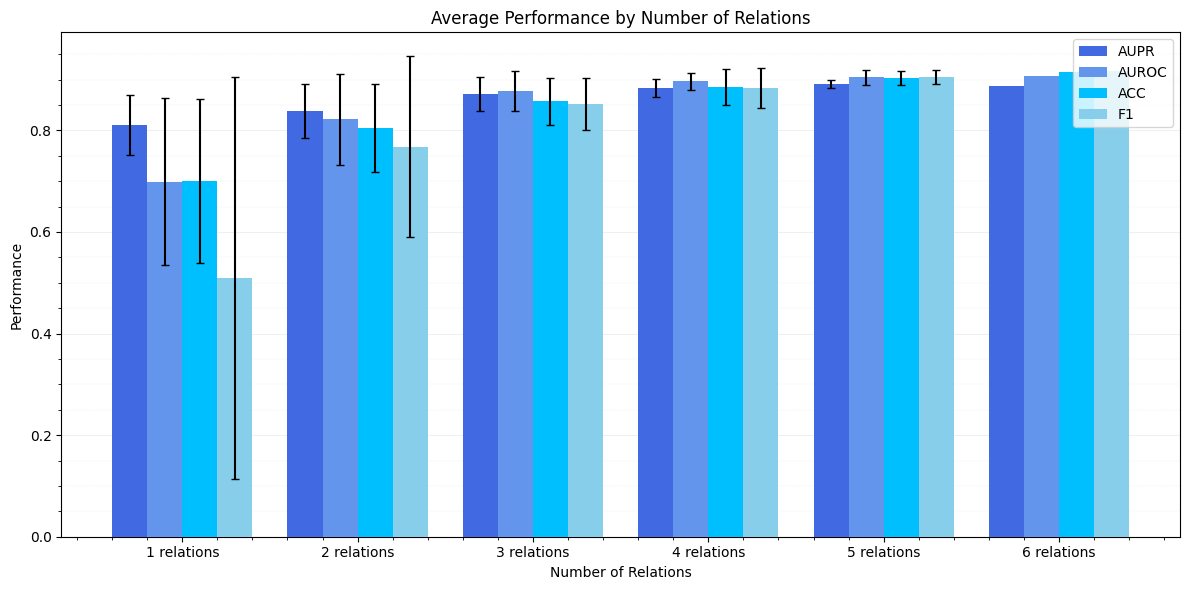

In [ ]:
plot_df = edge_table.copy()
for col in ["AUPR", "AUC", "Accuracy", "F1"]:
    plot_df[[f"{col}_mean", f"{col}_std"]] = (
        plot_df[col].str.split(r"\s*±\s*", expand=True).astype(float)
    )

plot_df["n_relations"] = plot_df["Relations"].apply(lambda x: len(x.split(" + ")))

grouped = (
    plot_df.groupby("n_relations")
    .agg(
        AUPR_mean=("AUPR_mean", "mean"),
        AUPR_std=("AUPR_mean", "std"),
        AUROC_mean=("AUC_mean", "mean"),
        AUROC_std=("AUC_mean", "std"),
        ACC_mean=("Accuracy_mean", "mean"),
        ACC_std=("Accuracy_mean", "std"),
        F1_mean=("F1_mean", "mean"),
        F1_std=("F1_mean", "std"),
    )
    .reset_index()
)

grouped["label"] = grouped["n_relations"].apply(lambda x: f"{x} relations")

n_groups = len(grouped)
index = np.arange(n_groups)
bar_width = 0.2

plt.figure(figsize=(12, 6))

plt.bar(
    index,
    grouped["AUPR_mean"],
    bar_width,
    yerr=grouped["AUPR_std"],
    capsize=3,
    label="AUPR",
    color="royalblue",
    zorder=3,
)
plt.bar(
    index + bar_width,
    grouped["AUROC_mean"],
    bar_width,
    yerr=grouped["AUROC_std"],
    capsize=3,
    label="AUROC",
    color="cornflowerblue",
    zorder=3,
)
plt.bar(
    index + 2 * bar_width,
    grouped["ACC_mean"],
    bar_width,
    yerr=grouped["ACC_std"],
    capsize=3,
    label="ACC",
    color="deepskyblue",
    zorder=3,
)
plt.bar(
    index + 3 * bar_width,
    grouped["F1_mean"],
    bar_width,
    yerr=grouped["F1_std"],
    capsize=3,
    label="F1",
    color="skyblue",
    zorder=3,
)

plt.grid(axis="y", alpha=0.5, lw=0.5, color="lightgrey", zorder=0)
plt.minorticks_on()
plt.grid(
    which="minor",
    axis="y",
    alpha=0.5,
    lw=0.25,
    linestyle="--",
    color="lightgrey",
    zorder=0,
)
# plt.ylim(0.6,1 )
plt.xlabel("Number of Relations")
plt.ylabel("Performance")
plt.title("Average Performance by Number of Relations")
plt.xticks(index + 1.5 * bar_width, grouped["label"])
plt.legend()
plt.tight_layout()
plt.savefig("../paper/figures/average_performance_by_number_of_relations.png", dpi=300)
plt.show()

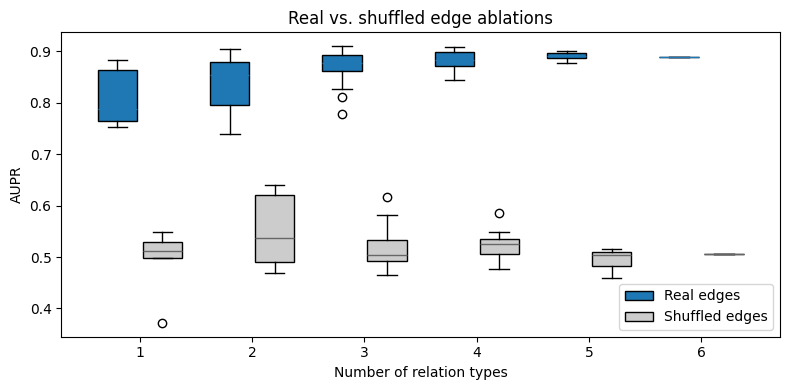

In [ ]:
real = pd.read_csv("../paper/tables/edge_ablations.csv")
rand = pd.read_csv("../paper/tables/randomized_edge_ablations.csv")


def n_relations(s: str) -> int:
    """Count how many relation types appear in the string"""
    return len([p for p in s.split("+") if p.strip()])


def numeric_part(cell) -> float:
    """Extract the first floating-point number in a string (before the ±)."""
    m = re.search(r"(\d+\.\d+)", str(cell))
    return float(m.group(1)) if m else np.nan


for df in (real, rand):
    df["n_rel"] = df["Relations"].apply(n_relations)
    df["AUPR_val"] = df.apply(
        lambda r: numeric_part(r["AUPR"])  # preferred column
        if pd.notna(r["AUPR"])
        else numeric_part(r["AUC"]),
        axis=1,
    )

n_values = sorted(real["n_rel"].unique())
real_data = [real.loc[real["n_rel"] == n, "AUPR_val"].dropna() for n in n_values]
rand_data = [rand.loc[rand["n_rel"] == n, "AUPR_val"].dropna() for n in n_values]

offset = 0.2
pos_real = [i - offset for i in range(len(n_values))]
pos_rand = [i + offset for i in range(len(n_values))]

fig, ax = plt.subplots(figsize=(8, 4))
bp1 = ax.boxplot(real_data, positions=pos_real, widths=0.35, patch_artist=True)
bp2 = ax.boxplot(rand_data, positions=pos_rand, widths=0.35, patch_artist=True)

# colours
for b in bp1["boxes"]:
    b.set_facecolor("#1f77b4")
for b in bp2["boxes"]:
    b.set_facecolor("#cccccc")
for m in bp1["medians"]:
    m.set_color("#1f77b4")
for m in bp2["medians"]:
    m.set_color("#666666")

# axes & legend
ax.set_xticks(range(len(n_values)))
ax.set_xticklabels(n_values)
ax.set_xlabel("Number of relation types")
ax.set_ylabel("AUPR")
ax.set_title("Real vs. shuffled edge ablations")
ax.legend(
    [bp1["boxes"][0], bp2["boxes"][0]],
    ["Real edges", "Shuffled edges"],
    loc="lower right",
)

plt.tight_layout()
plt.show()

/var/folders/fh/dk_7wcx551n03dv4ztv1_d740000gp/T/ipykernel_22327/226965762.py:43: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:k'` for the same effect.

  sns.swarmplot(


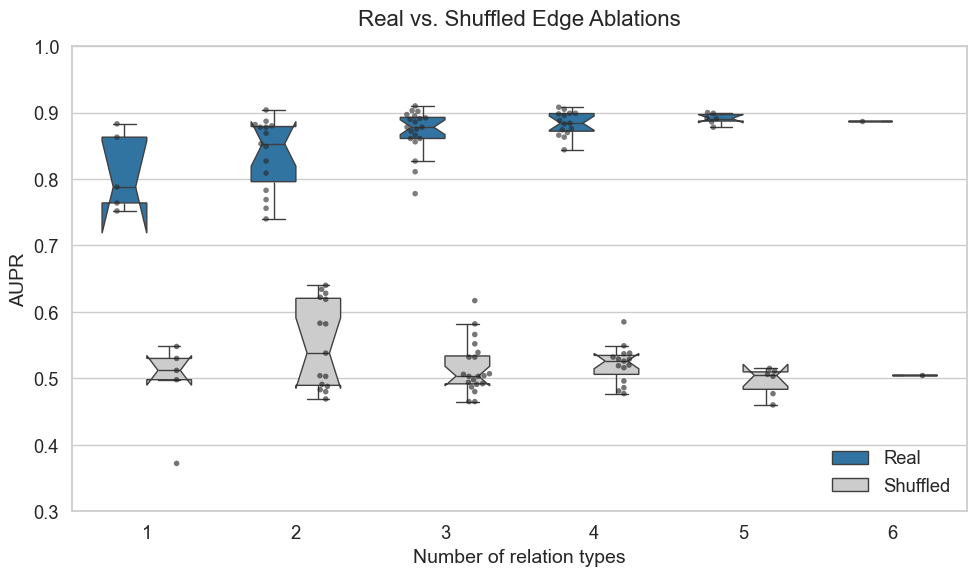

In [ ]:

real = pd.read_csv("../paper/tables/edge_ablations.csv")
rand = pd.read_csv("../paper/tables/randomized_edge_ablations.csv")


def n_relations(s: str) -> int:
    return len([p for p in s.split("+") if p.strip()])


def numeric_part(cell) -> float:
    m = re.search(r"(\d+\.\d+)", str(cell))
    return float(m.group(1)) if m else np.nan


for df, label in [(real, "Real"), (rand, "Shuffled")]:
    df["n_rel"] = df["Relations"].apply(n_relations)
    df["AUPR_val"] = df.apply(
        lambda r: numeric_part(r["AUPR"])
        if pd.notna(r["AUPR"])
        else numeric_part(r["AUC"]),
        axis=1,
    )
    df["Type"] = label

df_all = pd.concat([real, rand], ignore_index=True)

sns.set_theme(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(10, 6))

sns.boxplot(
    x="n_rel",
    y="AUPR_val",
    hue="Type",
    data=df_all,
    notch=True,
    palette={"Real": "#1f77b4", "Shuffled": "#cccccc"},
    width=0.6,
    fliersize=0,
)

sns.swarmplot(
    x="n_rel",
    y="AUPR_val",
    hue="Type",
    data=df_all,
    dodge=True,
    color="k",
    alpha=0.6,
    size=4,
)

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[:2], labels[:2], title="", loc="lower right")

plt.xlabel("Number of relation types", fontsize=14)
plt.ylabel("AUPR", fontsize=14)
plt.title("Real vs. Shuffled Edge Ablations", fontsize=16, pad=15)

plt.ylim(0.3, 1)

plt.tight_layout()
plt.show()

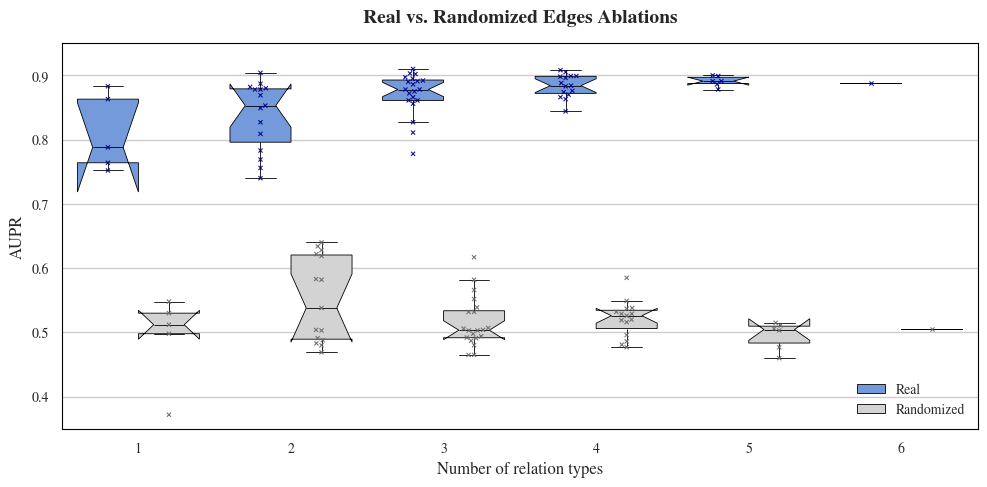

In [ ]:
real = pd.read_csv("../paper/tables/edge_ablations.csv")
rand = pd.read_csv("../paper/tables/randomized_edge_ablations.csv")


def n_relations(s):
    return len([p for p in s.split("+") if p.strip()])


def numeric_part(cell):
    m = re.search(r"(\d+\.\d+)", str(cell))
    return float(m.group(1)) if m else np.nan


for df, label in [(real, "Real"), (rand, "Randomized")]:
    df["n_rel"] = df["Relations"].apply(n_relations)
    df["AUPR_val"] = df.apply(
        lambda r: numeric_part(r["AUPR"])
        if pd.notna(r["AUPR"])
        else numeric_part(r["AUC"]),
        axis=1,
    )
    df["Type"] = label

df_all = pd.concat([real, rand], ignore_index=True)

sns.set_theme(
    style="whitegrid",
    font_scale=0.9,
    rc={
        "font.family": "serif",
        "font.serif": ["STIXGeneral"],
        "mathtext.fontset": "stix",
        "axes.edgecolor": "black",
        "axes.linewidth": 0.8,
    },
)
plt.figure(figsize=(10, 5))

box_palette = {"Real": "cornflowerblue", "Randomized": "lightgrey"}
sns.boxplot(
    x="n_rel",
    y="AUPR_val",
    hue="Type",
    data=df_all,
    notch=True,
    width=0.8,
    fliersize=0,
    palette=box_palette,
    dodge=True,
    # Black outlines everywhere
    boxprops=dict(edgecolor="black", linewidth=0.6),
    whiskerprops=dict(color="black", linewidth=0.6),
    capprops=dict(color="black", linewidth=0.6),
    medianprops=dict(color="black", linewidth=0.6),
)

swarm_palette = {"Real": "darkblue", "Randomized": "dimgrey"} 
sns.swarmplot(
    x="n_rel",
    y="AUPR_val",
    hue="Type",
    data=df_all,
    dodge=True,
    palette=swarm_palette,
    marker="x",
    size=3,
    linewidth=0.8,
    alpha=0.9,
)

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[:2], labels[:2], title="", loc="lower right")

plt.xlabel("Number of relation types", fontsize=12)
plt.ylabel("AUPR", fontsize=12)
plt.title("Real vs. Randomized Edges Ablations", fontsize=14, fontweight="bold", pad=15)
plt.ylim(0.35, 0.95)

plt.tight_layout()

plt.savefig("../paper/figures/real_vs_randomized_edges_ablations.png", dpi=300)
plt.show()

## Feature ablations

In [ ]:
feature_map = {
    "mf": "Mutation Frequency",
    "ge": "Gene Expression",
    "cna": "Copy Number Alterations",
    "meth": "Methylation",
}

def extract_features(name):
    name_l = name.lower()
    included = []
    for abbr, full in feature_map.items():
        if abbr in name_l:
            included.append(full)
    return " + ".join(sorted(included)) if included else "None"

feature_table["Features"] = feature_table["group_name"].apply(extract_features)
feature_table["num_features"] = feature_table["Features"].apply(
    lambda s: len(s.split(" + "))
)
feature_table = feature_table.sort_values(["num_features", "Features"]).drop(
    columns="num_features"
)
feature_table = feature_table[["Features", "AUPR", "AUC", "Accuracy", "F1"]]

In [51]:
feature_table.to_csv("../paper/tables/feature_ablations.csv", index=False)